In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from datetime import datetime, timezone
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union

#import os
#import glob

from pathlib import Path
import yaml
import re

import logging
import wandb

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import pyarrow.parquet as pq
import pyarrow as pa


import hashlib


# Custom Utilities Module
from utils.paths import get_paths
from utils.file_io import load_data, save_data
from utils.eda_logging import profile_dataframe
from utils.logging_setup import configure_logging
from utils.wandb_utils import finalize_wandb_stage

# Ledger 
from utils.ledger import Ledger

# Show more columns
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)



In [2]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [3]:
def log_silver_paths(paths, logger: logging.Logger) -> None:
    logger.info("Project Root Path Loaded: %s", paths.root)
    logger.info("Project Logging Path Loaded: %s", paths.logs)
    logger.info("Project Artifacts Path Loaded: %s", paths.artifacts)
    logger.info("Project Notebooks Path Loaded %s", paths.notebooks)
    logger.info("Project Data Path Loaded: %s", paths.data)
    logger.info("Data Bronze Path Loaded: %s", paths.data_bronze)
    logger.info("Data Bronze Training Path Loaded: %s", paths.data_bronze_train)
    logger.info("Data Bronze Testing Path Loaded: %s", paths.data_bronze_test)
    logger.info("Data Silver Path Loaded: %s", paths.data_silver)
    logger.info("Data Silver Training Path Loaded: %s", paths.data_silver_train)
    logger.info("Data Silver Testing Path Loaded: %s", paths.data_silver_test)


In [4]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [5]:
# Logging setup

# Get Path's Object
paths = get_paths()

# Create silver log path 
silver_log_path = paths.logs / "silver.log"

# Initial Logger
configure_logging(
    "capstone",
    silver_log_path,
    level=logging.DEBUG,
    overwrite_handlers=True,
)

# Initiate Logger and log file
logger = logging.getLogger("capstone.silver")

# Log load and initiation
logger.info("Silver stage starting")

# Log paths loads
log_silver_paths(paths, logger)


2026-01-04 05:08:54,014 | INFO | capstone.silver | Silver stage starting
2026-01-04 05:08:54,016 | INFO | capstone.silver | Project Root Path Loaded: /workspace
2026-01-04 05:08:54,017 | INFO | capstone.silver | Project Logging Path Loaded: /workspace/logs
2026-01-04 05:08:54,019 | INFO | capstone.silver | Project Artifacts Path Loaded: /workspace/artifacts
2026-01-04 05:08:54,021 | INFO | capstone.silver | Project Notebooks Path Loaded /workspace/notebooks
2026-01-04 05:08:54,023 | INFO | capstone.silver | Project Data Path Loaded: /workspace/data
2026-01-04 05:08:54,024 | INFO | capstone.silver | Data Bronze Path Loaded: /workspace/data/bronze
2026-01-04 05:08:54,026 | INFO | capstone.silver | Data Bronze Training Path Loaded: /workspace/data/bronze/train
2026-01-04 05:08:54,027 | INFO | capstone.silver | Data Bronze Testing Path Loaded: /workspace/data/bronze/test
2026-01-04 05:08:54,028 | INFO | capstone.silver | Data Silver Path Loaded: /workspace/data/silver
2026-01-04 05:08:54,0

In [6]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [7]:
# Configurables



#### #### #### #### #### #### #### #### 

# Stage Details
STAGE = "silver"
LAYER_NAME = "silver"

SILVER_VERSION = "silver__001"
CLEANING_RECIPE_ID = "silver__clean__dataset__agnostic__v001"

# Paths
BRONZE_TRAIN_DATA_PATH = paths.data_bronze_train
SILVER_TRAIN_DATA_PATH = paths.data_silver_train
SILVER_ARTIFACTS_PATH = paths.artifacts / "silver"
LOGS_PATH = paths.logs

# Path Failsafes
SILVER_TRAIN_DATA_PATH.mkdir(parents=True, exist_ok=True)
SILVER_ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)
LOGS_PATH.mkdir(parents=True, exist_ok=True)

BRONZE_TRAIN_DATA_FILE_NAME = "pump__bronze__train.parquet"
SILVER_TRAIN_DATA_FILE_NAME = "pump__silver__train.parquet"


# Defaults / Fallbacks
ASSET_ID_DEFAULT_FALLBACK = "asset__001"
RUN_ID_DEFAULT_FALLBACK = "run__001"

# QA/EDA thresholds
QUARANTINE_MISSING_PCT = 60.0
ROLLING_WINDOW = 100
TOP_PLOT_COLS = 8
TOP_CORR_COLS = 15

#### #### #### #### #### #### #### #### 

# Candidate lists

TIME_EVENT_COLUMN_CANDIDATES = ["timestamp", "datetime", "date_time", "event_time", "time", "ts", "step", "cycle"]
STATUS_COLUMN_CANDIDATES = ["machine_status", "status", "state", "condition"]
LABEL_COLUMN_CANDIDATES = ["anomaly_flag", "flaut_flag", "target", "label", "y"]

#### #### #### #### 

NORMAL_STATUS_VALUES = {"normal", "ok", "healthy", "running"} 

#### #### #### #### #### #### #### #### 

# Regex Matching

# Unnamed Column Names
UNNAMED_COLUMN_REGEX  = re.compile(r"^unnamed:\s*\d+(\.\d+)?$", flags=re.IGNORECASE)


#### #### #### #### #### #### #### #### 

# Weights and Biases

WANDB_PROJECT = "capstone"
WANDB_ENTITY = "dcoo230-western-governors-university"
WANDB_RUN_NAME = f"{SILVER_VERSION}"

# Lists

BRONZE_META_COLS = [
    "meta__dataset",
    "meta__split",
    "meta__run_id",
    "meta__asset_id",
    "meta__label_type",
    "meta__label_source",
    "meta__ingested_at_utc",
    "meta__source_file",
    "meta__source_row_id",
    "meta__record_id",
    "meta__schema_version"
]


SILVER_META_COLS_ADDED = [
    "meta__layer",
    "meta__processed_at",
    "meta__silver_version",
    "meta__cleaning_recipe",
    "meta__feature_set",
]



In [8]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [9]:
# W&B

wandb_run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=WANDB_RUN_NAME,
    job_type="silver",
    config={
        "silver_version": SILVER_VERSION,
        "cleaning_recipe_id": CLEANING_RECIPE_ID,
        "quarantine_missing_pct": QUARANTINE_MISSING_PCT,
        "rolling_window": ROLLING_WINDOW,
        "bronze_path": str(BRONZE_TRAIN_DATA_PATH / BRONZE_TRAIN_DATA_FILE_NAME),
        "silver_out_dir": str(SILVER_TRAIN_DATA_PATH),
    },
)
logger.info("W&B initialized: %s", wandb.run.name)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dcoo230 (dcoo230-western-governors-university). Use `wandb login --relogin` to force relogin


2026-01-04 05:08:57,743 | INFO | capstone.silver | W&B initialized: silver__001


In [10]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [11]:
# Ledger Setup

ledger = Ledger(stage=STAGE, recipe_id=CLEANING_RECIPE_ID)

ledger.add(
    kind="step",
    step="init",
    message="Initialized ledger",
    logger=logger
)


2026-01-04 05:08:58,326 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:08:58.326458+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'init', 'message': 'Initialized ledger', 'why': None, 'consequence': None, 'data': {}}


{'ts_utc': '2026-01-04T05:08:58.326458+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'init',
 'message': 'Initialized ledger',
 'why': None,
 'consequence': None,
 'data': {}}

In [12]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### ####

In [13]:
# Load Data
# dataframe = load_data(paths.data_bronze, "pump__bronze__train.parquet")

preferred_bronze = BRONZE_TRAIN_DATA_PATH / BRONZE_TRAIN_DATA_FILE_NAME

if preferred_bronze.exists():
    bronze_data_path = preferred_bronze
else:
    parquet_files = sorted(BRONZE_TRAIN_DATA_PATH.glob("*.parquet"))
    if len(parquet_files) == 0:
        raise FileNotFoundError(f"No parquet files found in {BRONZE_TRAIN_DATA_PATH}")
    if len(parquet_files) > 1: 
        logger.warning("Multiple Parquet Files found; Using First %s", parquet_files[0])
    bronze_data_path = parquet_files[0]


dataframe = load_data(BRONZE_TRAIN_DATA_PATH, BRONZE_TRAIN_DATA_FILE_NAME)

logger.info("Loaded Bronze: %s | shape=%s", preferred_bronze, dataframe.shape)
wandb_run.log({"bronze_rows": int(dataframe.shape[0]), "bronze_cols": int(dataframe.shape[1])})

ledger.add(
    kind="step",
    step="load_bronze",
    message="Loaded Bronze Parquet",
    why="Silver must be derived from reprodicible Bronze Artifact",
    consequence="All silver outputs trace back to this file",
    data={"bronze_path": str(BRONZE_TRAIN_DATA_PATH/BRONZE_TRAIN_DATA_FILE_NAME), "shape": list(dataframe.shape), "cols": len(dataframe.columns)},
    logger=logger
)

display(dataframe.head(3))

2026-01-04 05:08:58,841 | INFO | capstone.file_io | Loading Parquet: /workspace/data/bronze/train/pump__bronze__train.parquet
2026-01-04 05:08:59,459 | INFO | capstone.silver | Loaded Bronze: /workspace/data/bronze/train/pump__bronze__train.parquet | shape=(220320, 65)
2026-01-04 05:08:59,462 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:08:59.462537+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'load_bronze', 'message': 'Loaded Bronze Parquet', 'why': 'Silver must be derived from reprodicible Bronze Artifact', 'consequence': 'All silver outputs trace back to this file', 'data': {'bronze_path': '/workspace/data/bronze/train/pump__bronze__train.parquet', 'shape': [220320, 65], 'cols': 65}}


,meta__dataset,meta__split,meta__run_id,meta__asset_id,meta__label_type,meta__label_source,meta__ingested_at_utc,meta__source_file,meta__source_row_id,meta__record_id,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,PUMP,unsplit,run__001,asset__001,<NA>,<NA>,2026-01-04 04:23:17.910706+00:00,sensor.csv,0,14598431322315673869,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,PUMP,unsplit,run__001,asset__001,<NA>,<NA>,2026-01-04 04:23:17.910706+00:00,sensor.csv,1,15954729095895098000,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,PUMP,unsplit,run__001,asset__001,<NA>,<NA>,2026-01-04 04:23:17.910706+00:00,sensor.csv,2,10041703297090838359,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.39757,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL


In [14]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [15]:
# Add Layer Tag
dataframe["meta__layer"] = LAYER_NAME

# Add Silver Processing Column and timestamp start
dataframe["meta__processed_at"] = pd.Timestamp.now(tz="UTC")

# Add Silver Version Meta Column
dataframe["meta__silver_version"] = SILVER_VERSION

# Add Silver Cleaning Recipe ID Meta Column
if "meta__cleaning_recipe" not in dataframe.columns:
    dataframe["meta__cleaning_recipe"] = pd.NA
dataframe["meta__cleaning_recipe"] = CLEANING_RECIPE_ID

# Ensure Meta Run ID and Meta Asset ID columns exist and if not add them with fallbacks
if "meta__run_id" not in dataframe.columns:
    dataframe["meta__run_id"] = RUN_ID_DEFAULT_FALLBACK

if "meta__asset_id" not in dataframe.columns:
    dataframe["meta__asset_id"] = ASSET_ID_DEFAULT_FALLBACK 

# Ensure label meta fields exist and if not add with Pandas Nulls
if "meta__label_type" not in dataframe.columns:
    dataframe["meta__label_type"] = pd.NA

if "meta__label_source" not in dataframe.columns:
    dataframe["meta__label_source"] = pd.NA

# Features Set Placeholder
for column in ["meta__feature_set"]:
    if column not in dataframe.columns:
        dataframe[column] = pd.NA

ledger.add(
    kind="step",
    step="apply_silver_meta",
    message="Applied Silver meta columns and ensured identity fields exist",
    data={"silver_version": SILVER_VERSION, "cleaning_recipe": CLEANING_RECIPE_ID},
    logger=logger,
)



2026-01-04 05:09:00,109 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:00.109211+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'apply_silver_meta', 'message': 'Applied Silver meta columns and ensured identity fields exist', 'why': None, 'consequence': None, 'data': {'silver_version': 'silver__001', 'cleaning_recipe': 'silver__clean__dataset__agnostic__v001'}}


{'ts_utc': '2026-01-04T05:09:00.109211+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'apply_silver_meta',
 'message': 'Applied Silver meta columns and ensured identity fields exist',
 'why': None,
 'consequence': None,
 'data': {'silver_version': 'silver__001',
  'cleaning_recipe': 'silver__clean__dataset__agnostic__v001'}}

In [16]:
def infer_time_column(dataframe: pd.DataFrame, candidates: list[str]) -> tuple[str | None, dict]:
    for column in candidates:
        if column in dataframe.columns:
            parsed = pd.to_datetime(dataframe[column], errors="coerce", utc=True)
            success_pct = float(parsed.notna().mean() * 100)
            if success_pct >= 80.0:
                return column, {"parse_success_pct": success_pct}
    return None, {"parse_success_pct": 0.0}




def infer_label_or_status_column(dataframe: pd.DataFrame, label_candidates: list[str], status_candidates: list[str]) -> tuple[str | None, str, dict]:
    for column in label_candidates:
        if column in dataframe.columns:
            return column, "label", {"top_values": dataframe[column].value_counts(dropna=False).head(10).to_dict()}
    for column in status_candidates:
        if column in dataframe.columns:
            return column, "status", {"top_values": dataframe[column].value_counts(dropna=False).head(10).to_dict()}
    return None, "none", {"top_values": {}}




In [17]:
# Infer Time/Event Columns
time_event_column, time_event_info = infer_time_column(dataframe, TIME_EVENT_COLUMN_CANDIDATES)

# Infer Label / Status Columns
label_status_column, label_status_kind, label_status_info = infer_label_or_status_column(dataframe, LABEL_COLUMN_CANDIDATES, STATUS_COLUMN_CANDIDATES)


In [18]:
if time_event_column is None:
    raise ValueError("No usable time column inferred; Silver requires time ordering for this workflow.")

TIME_EVENT_COLUMN = time_event_column
LABEL_STATUS_COLUMN = label_status_column
LABEL_STATUS_KIND = label_status_kind



ledger.add(
    kind="decision",
    step="infer_columns",
    message="Inferred and locked time + label/status columns for this notebook run",
    why="Dataset-agnostic column selection avoids reliance on external documentation and supports multi-dataset pipeline goals",
    consequence="Downstream time parsing and anomaly mapping uses the locked selections",
    data={
        "time_col": TIME_EVENT_COLUMN,
        "time_info": time_event_info,
        "label_status_col": LABEL_STATUS_COLUMN,
        "label_status_kind": LABEL_STATUS_KIND,
        "label_status_top_values": label_status_info.get("top_values", {}),
    },
    logger=logger,
)

(TIME_EVENT_COLUMN, LABEL_STATUS_COLUMN, LABEL_STATUS_KIND)


2026-01-04 05:09:01,035 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:01.035806+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'decision', 'step': 'infer_columns', 'message': 'Inferred and locked time + label/status columns for this notebook run', 'why': 'Dataset-agnostic column selection avoids reliance on external documentation and supports multi-dataset pipeline goals', 'consequence': 'Downstream time parsing and anomaly mapping uses the locked selections', 'data': {'time_col': 'timestamp', 'time_info': {'parse_success_pct': 100.0}, 'label_status_col': 'machine_status', 'label_status_kind': 'status', 'label_status_top_values': {'NORMAL': 205836, 'RECOVERING': 14477, 'BROKEN': 7}}}


('timestamp', 'machine_status', 'status')

In [19]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [20]:
dataframe["event_time"] = pd.to_datetime(dataframe[TIME_EVENT_COLUMN], errors="coerce", utc=True)
dataframe["event_step"] = np.arange(len(dataframe), dtype=np.int64)

parse_success_pct = float(dataframe["event_time"].notna().mean() * 100)

diffs = dataframe["event_time"].sort_values().diff().dropna()
median_sec = float(diffs.dt.total_seconds().median()) if len(diffs) else np.nan

wandb_run.log({"event_time_parse_success_pct": parse_success_pct, "median_sampling_interval_sec": median_sec})

ledger.add(
    kind="step",
    step="event_fields",
    message="Created event_time and event_step",
    data={"time_event_column": TIME_EVENT_COLUMN, "parse_success_pct": parse_success_pct, "median_interval_sec": median_sec},
    logger=logger,
)

2026-01-04 05:09:01,648 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:01.648931+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'event_fields', 'message': 'Created event_time and event_step', 'why': None, 'consequence': None, 'data': {'time_event_column': 'timestamp', 'parse_success_pct': 100.0, 'median_interval_sec': 60.0}}


{'ts_utc': '2026-01-04T05:09:01.648931+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'event_fields',
 'message': 'Created event_time and event_step',
 'why': None,
 'consequence': None,
 'data': {'time_event_column': 'timestamp',
  'parse_success_pct': 100.0,
  'median_interval_sec': 60.0}}

In [21]:
if LABEL_STATUS_COLUMN is None:
    dataframe["anomaly_flag"] = 0
    dataframe["meta__label_type"] = "anomaly_flag"
    dataframe["meta__label_source"] = "No label/status column inferred; anomaly_flag defaulted to 0"
else:
    if LABEL_STATUS_KIND == "status":
        status_norm = dataframe[LABEL_STATUS_COLUMN].astype("string").str.strip().str.upper()
        dataframe["anomaly_flag"] = (status_norm != "NORMAL").astype("int8")

        dataframe["meta__label_type"] = "anomaly_flag"
        dataframe["meta__label_source"] = f"{LABEL_STATUS_COLUMN}: status != 'NORMAL' (non-NORMAL treated as anomalous)"
    else:
        raw = dataframe[LABEL_STATUS_COLUMN]
        if raw.dtype == bool:
            dataframe["anomaly_flag"] = raw.astype("int8")
            rule = "bool->int8"
        elif pd.api.types.is_numeric_dtype(raw):
            dataframe["anomaly_flag"] = (pd.to_numeric(raw, errors="coerce").fillna(0) != 0).astype("int8")
            rule = "numeric nonzero->1"
        else:
            truthy = {"1","true","yes","y","anomaly","fault","fail","broken","abnormal"}
            s = raw.astype("string").str.strip().str.lower()
            dataframe["anomaly_flag"] = s.isin(truthy).astype("int8")
            rule = f"string in {sorted(truthy)}"

        dataframe["meta__label_type"] = "anomaly_flag"
        dataframe["meta__label_source"] = f"Normalized from {LABEL_STATUS_COLUMN} using rule: {rule}"

counts = dataframe["anomaly_flag"].value_counts().sort_index()
display(counts)

wandb_run.log({
    "anomaly_0": int(counts.get(0, 0)),
    "anomaly_1": int(counts.get(1, 0)),
})

ledger.add(
    kind="decision",
    step="label",
    message="Derived anomaly_flag and finalized label metadata",
    why="Binary label is required for split EDA, modeling, and synthetic generator justification",
    consequence="Non-NORMAL states are treated as anomalous; abnormal segment may be dominated by intermediate states (e.g., RECOVERING)",
    data={"anomaly_counts": counts.to_dict(), "label_status_col": LABEL_STATUS_COLUMN, "kind": LABEL_STATUS_KIND},
    logger=logger,
)


anomaly_flag
0    205836
1     14484
Name: count, dtype: int64

2026-01-04 05:09:01,996 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:01.996590+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'decision', 'step': 'label', 'message': 'Derived anomaly_flag and finalized label metadata', 'why': 'Binary label is required for split EDA, modeling, and synthetic generator justification', 'consequence': 'Non-NORMAL states are treated as anomalous; abnormal segment may be dominated by intermediate states (e.g., RECOVERING)', 'data': {'anomaly_counts': {0: 205836, 1: 14484}, 'label_status_col': 'machine_status', 'kind': 'status'}}


{'ts_utc': '2026-01-04T05:09:01.996590+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'decision',
 'step': 'label',
 'message': 'Derived anomaly_flag and finalized label metadata',
 'why': 'Binary label is required for split EDA, modeling, and synthetic generator justification',
 'consequence': 'Non-NORMAL states are treated as anomalous; abnormal segment may be dominated by intermediate states (e.g., RECOVERING)',
 'data': {'anomaly_counts': {0: 205836, 1: 14484},
  'label_status_col': 'machine_status',
  'kind': 'status'}}

In [24]:
source_column = "anomaly_flag"
boolean_column = "anomaly_flag_bool"


if source_column in dataframe.columns:
    
    needs_create = (
        boolean_column not in dataframe.columns
        or not pd.api.types.is_bool_dtype(dataframe[boolean_column])
    )

    if needs_create:
        dtype_before = str(dataframe[source_column].dtype)
        
        dataframe[boolean_column] = dataframe[source_column].astype("boolean")

        dtype_after = str(dataframe[boolean_column].dtype)


        # JSON-safe counts (convert to plain Python int/str)
        anomaly_counts_int = (
            dataframe[source_column]
            .value_counts(dropna=False)
            .to_dict()
        )

        anomaly_counts_int = {str(k): int(v) for k, v in anomaly_counts_int.items()}

        anomaly_counts_bool = (
            dataframe[boolean_column]
            .value_counts(dropna=False)
            .to_dict()
        )
        # keys are True/False/NaN; normalize keys to strings
        anomaly_counts_bool = {str(k): int(v) for k, v in anomaly_counts_bool.items()}

        ledger.add(
            kind="step",
            step="label",
            message="Added anomaly_flag_bool derived from anomaly_flag (int8)",
            why="Keep canonical label as compact int8 for modeling/storage, but add a boolean shadow for EDA (e.g., describe(include='bool')) and readability.",
            consequence="Modeling continues to use anomaly_flag; anomaly_flag_bool is informational/EDA-only and must not be treated as a separate label source.",
            data={
                "source_column": source_column,
                "output_column": boolean_column,
                "dtype_before": dtype_before,
                "dtype_after": dtype_after,
                "mapping": "Cast anomaly_flag to pandas nullable boolean; NA preserved.",
                "counts_int8": anomaly_counts_int,
                "counts_bool": anomaly_counts_bool,
            },
            logger=logger,
        )
    else:
        ledger.add(
                    kind="decision",
                    step="label",
                    message="Skipped anomaly_flag_bool creation (already exists)",
                    why="anomaly_flag_bool already present and boolean-typed",
                    consequence="No change to label helper column.",
                    data={
                        "source_column": source_column,
                        "output_column": boolean_column,
                        "dtype_existing": str(dataframe[boolean_column].dtype),
                    },
                    logger=logger,
                )
else:
    ledger.add(
        kind="decision",
        step="label",
        message="Skipped anomaly_flag_bool creation",
        why="anomaly_flag column not present",
        consequence="No boolean label helper column available for EDA boolean summaries.",
        data={"expected_column": source_column},
        logger=logger,
    )


2026-01-04 05:09:42,666 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:42.666294+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'decision', 'step': 'label', 'message': 'Skipped anomaly_flag_bool creation (already exists)', 'why': 'anomaly_flag_bool already present and boolean-typed', 'consequence': 'No change to label helper column.', 'data': {'source_column': 'anomaly_flag', 'output_column': 'anomaly_flag_bool', 'dtype_existing': 'boolean'}}


In [25]:
unnamed_columns = [column for column in dataframe.columns if UNNAMED_COLUMN_REGEX.search(str(column))]
if unnamed_columns:
    dataframe = dataframe.drop(columns=unnamed_columns)

ledger.add(
    kind="step",
    step="drop_unnamed",
    message="Dropped unnamed columns",
    data={"dropped": unnamed_columns},
    logger=logger,
)
logger.info("Dropped unnamed columns: %s", unnamed_columns)


2026-01-04 05:09:52,288 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:09:52.288928+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'drop_unnamed', 'message': 'Dropped unnamed columns', 'why': None, 'consequence': None, 'data': {'dropped': ['Unnamed: 0']}}
2026-01-04 05:09:52,291 | INFO | capstone.silver | Dropped unnamed columns: ['Unnamed: 0']


In [27]:
# Basic Dataframe Information/Summary

print("\nDataframe Information:")
dataframe.info()

print("Shape:", dataframe.shape)
print("\nData types:")
print(dataframe.dtypes)

print("\nMemory usage (MB):")
mem_mb = dataframe.memory_usage(deep=True).sum() / (1024 ** 2)
print(mem_mb)

print("\nFirst 15 rows:")
display(dataframe.head(15))

print("\nBasic numeric summary:")
display(dataframe.describe().T)

print("\nBasic object / categorical summary:")
display(dataframe.describe(include=["object", "category", "string"]).T)

print("\nBasic Boolean summary:")
display(dataframe.describe(include=["bool", "boolean"]).T)

wandb_run.log({"memory_mb": float(mem_mb)})

ledger.add(
    kind="step",
    step="baseline_eda",
    message="Captured baseline dataframe summary",
    data={"shape": list(dataframe.shape), "memory_mb": float(mem_mb)},
    logger=logger,
)


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 73 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   meta__dataset          220320 non-null  category           
 1   meta__split            220320 non-null  category           
 2   meta__run_id           220320 non-null  object             
 3   meta__asset_id         220320 non-null  object             
 4   meta__label_type       220320 non-null  object             
 5   meta__label_source     220320 non-null  object             
 6   meta__ingested_at_utc  220320 non-null  datetime64[us, UTC]
 7   meta__source_file      220320 non-null  string             
 8   meta__source_row_id    220320 non-null  int64              
 9   meta__record_id        220320 non-null  uint64             
 10  timestamp              220320 non-null  object             
 11  sensor_00      

,meta__dataset,meta__split,meta__run_id,meta__asset_id,meta__label_type,meta__label_source,meta__ingested_at_utc,meta__source_file,meta__source_row_id,meta__record_id,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,meta__layer,meta__processed_at,meta__silver_version,meta__cleaning_recipe,meta__feature_set,event_time,event_step,anomaly_flag,anomaly_flag_bool
0,PUMP,unsplit,run__001,asset__001,anomaly_flag,machine_status: status != 'NORMAL' (non-NORMAL...,2026-01-04 04:23:17.910706+00:00,sensor.csv,0,14598431322315673869,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,silver,2026-01-04 05:09:00.093377+00:00,silver__001,silver__clean__dataset__agnostic__v001,<NA>,2018-04-01 00:00:00+00:00,0,0,False
1,PUMP,unsplit,run__001,asset__001,anomaly_flag,machine_status: status != 'NORMAL' (non-NORMAL...,2026-01-04 04:23:17.910706+00:00,sensor.csv,1,15954729095895098000,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.989580,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,silver,2026-01-04 05:09:00.093377+00:00,silver__001,silver__clean__dataset__agnostic__v001,<NA>,2018-04-01 00:01:00+00:00,1,0,False
2,PUMP,unsplit,run__001,asset__001,anomaly_flag,machine_status: status != 'NORMAL' (non-NORMAL...,2026-01-04 04:23:17.910706+00:00,sensor.csv,2,10041703297090838359,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.468750,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,silver,2026-01-04 05:09:00.093377+00:00,silver__001,silver__clean__dataset__agnostic__v001,<NA>,2018-04-01 00:02:00+00:00,2,0,False
3,PUMP,unsplit,run__001,asset__001,anomaly_flag,machine_status: status != 'NORMAL' (non-NORMAL...,2026-01-04 04:23:17.910706+00:00,sensor.csv,3,2072036352569063261,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.468750,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,silver,2026-01-04 05:09:00.093377+00:00,silver__001,silver__clean__dataset__agnostic__v001,<NA>,2018-04-01 00:0


Basic numeric summary:


,count,mean,std,min,25%,50%,75%,max
meta__source_row_id,220320.0,1.101595e+05,6.360105e+04,0.000000e+00,5.507975e+04,1.101595e+05,1.652392e+05,2.203190e+05
meta__record_id,220320.0,9.224243e+18,5.322367e+18,1.873763e+14,4.610703e+18,9.220552e+18,1.381850e+19,1.844674e+19
sensor_00,210112.0,2.372221e+00,4.122274e-01,0.000000e+00,2.438831e+00,2.456539e+00,2.499826e+00,2.549016e+00
sensor_01,219951.0,4.759161e+01,3.296666e+00,0.000000e+00,4.631076e+01,4.813368e+01,4.947916e+01,5.672743e+01
sensor_02,220301.0,5.086739e+01,3.666820e+00,3.315972e+01,5.039062e+01,5.164930e+01,5.277777e+01,5.603299e+01
sensor_03,220301.0,4.375248e+01,2.418887e+00,3.164062e+01,4.283854e+01,4.422743e+01,4.531250e+01,4.822049e+01
sensor_04,220301.0,5.906739e+02,1.440239e+02,2.798032e+00,6.266204e+02,6.326389e+02,6.376157e+02,8.000000e+02
sensor_05,220301.0,7.339641e+01,1.729825e+01,0.000000e+00,6.997626e+01,7.557679e+01,8.091215e+01,9.999988e+01
sensor_06,215522.0,1.350154e+01,2.163736e+00,1.446759e-02,1.334635e+01,1.364294e+01,1.453993e+01,2.225116e+01
sensor_07,214869.0,1.584315e+01,2.201155e+00,0.000000e+00,1.590712e+01,1.616753e+01,1.642795e+01,2.359664e+01



Basic object / categorical summary:


,count,unique,top,freq
meta__dataset,220320,1,PUMP,220320
meta__split,220320,1,unsplit,220320
meta__run_id,220320,1,run__001,220320
meta__asset_id,220320,1,asset__001,220320
meta__label_type,220320,1,anomaly_flag,220320
meta__label_source,220320,1,machine_status: status != 'NORMAL' (non-NORMAL...,220320
meta__source_file,220320,1,sensor.csv,220320
timestamp,220320,220320,2018-08-31 23:43:00,1
machine_status,220320,3,NORMAL,205836
meta__layer,220320,1,silver,220320



Basic Boolean summary:


,count,unique,top,freq
anomaly_flag_bool,220320,2,False,205836


2026-01-04 05:10:35,083 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:35.083280+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'baseline_eda', 'message': 'Captured baseline dataframe summary', 'why': None, 'consequence': None, 'data': {'shape': [220320, 73], 'memory_mb': 269.6313257217407}}


{'ts_utc': '2026-01-04T05:10:35.083280+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'baseline_eda',
 'message': 'Captured baseline dataframe summary',
 'why': None,
 'consequence': None,
 'data': {'shape': [220320, 73], 'memory_mb': 269.6313257217407}}

In [28]:
meta_columns = [column for column in dataframe.columns if str(column).startswith("meta__")]
exclude = set(meta_columns + ["anomaly_flag", "event_time", "event_step", TIME_EVENT_COLUMN])

if LABEL_STATUS_COLUMN is not None:
    exclude.add(LABEL_STATUS_COLUMN)

candidate_columns = [column for column in dataframe.columns if column not in exclude]
numeric_sensors = dataframe[candidate_columns].select_dtypes(include=[np.number]).columns.tolist()

logger.info("Numeric sensor count: %d", len(numeric_sensors))
wandb_run.log({"numeric_sensor_count": int(len(numeric_sensors))})

ledger.add(
    kind="step",
    step="sensor_set",
    message="Identified numeric sensor feature set",
    data={"numeric_sensor_count": len(numeric_sensors)},
    logger=logger,
)


2026-01-04 05:10:39,567 | INFO | capstone.silver | Numeric sensor count: 52
2026-01-04 05:10:39,570 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:39.570433+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'sensor_set', 'message': 'Identified numeric sensor feature set', 'why': None, 'consequence': None, 'data': {'numeric_sensor_count': 52}}


{'ts_utc': '2026-01-04T05:10:39.570433+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'sensor_set',
 'message': 'Identified numeric sensor feature set',
 'why': None,
 'consequence': None,
 'data': {'numeric_sensor_count': 52}}

In [29]:
missing_pct = dataframe[numeric_sensors].isna().mean().sort_values(ascending=False) * 100
display(missing_pct.head(20).to_frame("pct_missing"))

drop_sensors = missing_pct[missing_pct >= QUARANTINE_MISSING_PCT].index.tolist()
if drop_sensors:
    dataframe = dataframe.drop(columns=drop_sensors)
    numeric_sensors = [c for c in numeric_sensors if c not in drop_sensors]

logger.info("Dropped sensors for missingness: %s", drop_sensors)
wandb_run.log({"dropped_sensors_missingness_count": int(len(drop_sensors))})

ledger.add(
    kind="decision",
    step="missingness_quarantine",
    message="Dropped sensors exceeding missingness threshold",
    why="High-missingness sensors add noise and instability to correlation and modeling",
    consequence="Feature set shrinks; downstream imputation/stats operate on remaining sensors",
    data={"threshold_pct": QUARANTINE_MISSING_PCT, "dropped": drop_sensors, "remaining": len(numeric_sensors)},
    logger=logger,
)


,pct_missing
sensor_15,100.000000
sensor_50,34.956881
sensor_51,6.982117
sensor_00,4.633261
sensor_07,2.474129
sensor_08,2.317992
sensor_06,2.177741
sensor_09,2.085603
sensor_01,0.167484
sensor_30,0.118464


2026-01-04 05:10:40,022 | INFO | capstone.silver | Dropped sensors for missingness: ['sensor_15']
2026-01-04 05:10:40,025 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:40.025163+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'decision', 'step': 'missingness_quarantine', 'message': 'Dropped sensors exceeding missingness threshold', 'why': 'High-missingness sensors add noise and instability to correlation and modeling', 'consequence': 'Feature set shrinks; downstream imputation/stats operate on remaining sensors', 'data': {'threshold_pct': 60.0, 'dropped': ['sensor_15'], 'remaining': 51}}


{'ts_utc': '2026-01-04T05:10:40.025163+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'decision',
 'step': 'missingness_quarantine',
 'message': 'Dropped sensors exceeding missingness threshold',
 'why': 'High-missingness sensors add noise and instability to correlation and modeling',
 'consequence': 'Feature set shrinks; downstream imputation/stats operate on remaining sensors',
 'data': {'threshold_pct': 60.0, 'dropped': ['sensor_15'], 'remaining': 51}}

In [30]:
nulls_before = int(dataframe[numeric_sensors].isna().sum().sum())

fill_vals = dataframe[numeric_sensors].median(numeric_only=True)
dataframe[numeric_sensors] = dataframe[numeric_sensors].fillna(fill_vals)

nulls_after = int(dataframe[numeric_sensors].isna().sum().sum())

logger.info("Impute nulls: before=%d after=%d", nulls_before, nulls_after)
wandb_run.log({"sensor_nulls_before": nulls_before, "sensor_nulls_after": nulls_after})

ledger.add(
    kind="step",
    step="impute",
    message="Imputed remaining numeric sensor nulls using median",
    data={"nulls_before": nulls_before, "nulls_after": nulls_after},
    logger=logger,
)


2026-01-04 05:10:40,715 | INFO | capstone.silver | Impute nulls: before=124254 after=0
2026-01-04 05:10:40,717 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:40.717797+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'impute', 'message': 'Imputed remaining numeric sensor nulls using median', 'why': None, 'consequence': None, 'data': {'nulls_before': 124254, 'nulls_after': 0}}


{'ts_utc': '2026-01-04T05:10:40.717797+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'impute',
 'message': 'Imputed remaining numeric sensor nulls using median',
 'why': None,
 'consequence': None,
 'data': {'nulls_before': 124254, 'nulls_after': 0}}

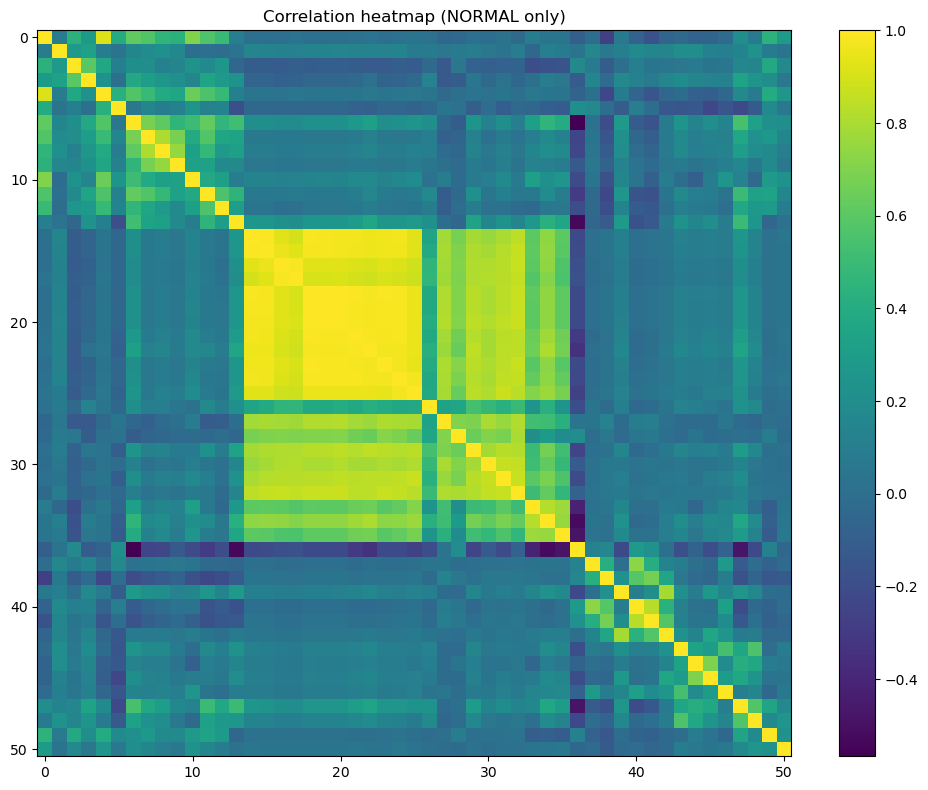

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
2026-01-04 05:10:42,839 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:42.839637+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'corr_normal', 'message': 'Computed normal-only correlation matrix', 'why': None, 'consequence': None, 'data': {'corr_csv': '/workspace/artifacts/silver/corr_normal.csv'}}


{'ts_utc': '2026-01-04T05:10:42.839637+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'corr_normal',
 'message': 'Computed normal-only correlation matrix',
 'why': None,
 'consequence': None,
 'data': {'corr_csv': '/workspace/artifacts/silver/corr_normal.csv'}}

In [31]:
normal_dataframe = dataframe[dataframe["anomaly_flag"] == 0]
correlation = normal_dataframe[numeric_sensors].corr()

fig = plt.figure(figsize=(10, 8))
plt.imshow(correlation, aspect="auto")
plt.title("Correlation heatmap (NORMAL only)")
plt.colorbar()
plt.tight_layout()
plt.show()

corr_path = SILVER_ARTIFACTS_PATH / "corr_normal.csv"
correlation.to_csv(corr_path)
wandb.save(str(corr_path))

ledger.add(
    kind="step",
    step="corr_normal",
    message="Computed normal-only correlation matrix",
    data={"corr_csv": str(corr_path)},
    logger=logger,
)


In [32]:
normal_stats = dataframe[dataframe["anomaly_flag"] == 0][numeric_sensors].describe().T.add_prefix("normal__")
abnormal_stats = dataframe[dataframe["anomaly_flag"] == 1][numeric_sensors].describe().T.add_prefix("abnormal__")

stats = normal_stats.join(abnormal_stats, how="outer")
stats["delta__mean"] = stats["abnormal__mean"] - stats["normal__mean"]
stats["delta__std"] = stats["abnormal__std"] - stats["normal__std"]

display(stats.head(20))

stats_path = SILVER_ARTIFACTS_PATH / "sensor_stats_normal_vs_abnormal.csv"
stats.to_csv(stats_path)
wandb.save(str(stats_path))

ledger.add(
    kind="step",
    step="sensor_stats_split",
    message="Computed per-sensor stats split by anomaly_flag",
    data={"stats_csv": str(stats_path), "sensor_count": len(numeric_sensors)},
    logger=logger,
)


,normal__count,normal__mean,normal__std,normal__min,normal__25%,normal__50%,normal__75%,normal__max,abnormal__count,abnormal__mean,abnormal__std,abnormal__min,abnormal__25%,abnormal__50%,abnormal__75%,abnormal__max,delta__mean,delta__std
sensor_00,205836.0,2.420478,0.242464,0.000000,2.444734,2.456539,2.499826,2.549016,14484.0,1.745844,1.099677,0.000000,0.109201,2.456539,2.456539,2.456539,-0.674635,0.857213
sensor_01,205836.0,48.180039,2.238328,0.000000,46.701390,48.263890,49.565970,56.727430,14484.0,39.243107,4.385140,32.204860,35.373264,38.671880,41.059020,53.559020,-8.936932,2.146812
sensor_02,205836.0,51.636950,1.878235,37.413190,50.651040,51.736111,52.907986,56.032990,14484.0,39.932023,5.135754,33.159720,36.067707,38.715275,42.274300,53.559020,-11.704927,3.257518
sensor_03,205836.0,44.167064,1.668204,33.289930,43.142361,44.357635,45.355900,48.220490,14484.0,37.861350,3.506842,31.640620,34.895830,37.717014,40.538190,46.701390,-6.305714,1.838638
sensor_04,205836.0,625.673758,50.820988,2.798032,628.240700,633.333313,637.963000,800.000000,14484.0,93.337151,118.505041,2.798032,3.336227,3.567708,203.029495,632.638916,-532.336606,67.684052
sensor_05,205836.0,75.389777,9.381388,0.000000,70.501472,75.647165,80.602508,99.999880,14484.0,45.071060,49.415498,0.000000,0.000000,0.000000,99.999878,99.999880,-30.318716,40.034110
sensor_06,205836.0,13.865057,0.864916,0.014468,13.382520,13.679110,14.568870,15.964990,14484.0,8.382299,5.563927,0.014468,0.028935,10.098380,13.642940,22.251160,-5.482759,4.699011
sensor_07,205836.0,16.165959,0.600437,0.028935,15.950520,16.167530,16.427950,19.133390,14484.0,11.377731,6.736060,0.000000,9.852430,15.082470,16.167530,23.596640,-4.788228,6.135623
sensor_08,205836.0,15.478130,0.588586,0.028935,15.183740,15.494790,15.697340,19.538480,14484.0,11.362074,6.399898,0.028935,10.098380,12.818290,15.494790,24.348960,-4.116056,5.811313
sensor_09,205836.0,15.086661,0.572950,0.007234,15.053530,15.082470,15.118630,18.988710,14484.0,10.804017,6.588480,0.000000,8.796296,15.010130,15.082470,25.000000,-4.282644,6.015530


2026-01-04 05:10:44,109 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:44.109605+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'sensor_stats_split', 'message': 'Computed per-sensor stats split by anomaly_flag', 'why': None, 'consequence': None, 'data': {'stats_csv': '/workspace/artifacts/silver/sensor_stats_normal_vs_abnormal.csv', 'sensor_count': 51}}


{'ts_utc': '2026-01-04T05:10:44.109605+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'sensor_stats_split',
 'message': 'Computed per-sensor stats split by anomaly_flag',
 'why': None,
 'consequence': None,
 'data': {'stats_csv': '/workspace/artifacts/silver/sensor_stats_normal_vs_abnormal.csv',
  'sensor_count': 51}}

,abs_delta_mean
sensor_04,532.336606
sensor_28,256.811665
sensor_31,181.338496
sensor_50,156.132333
sensor_32,143.352422
sensor_48,121.637976
sensor_23,112.581465
sensor_30,90.218034


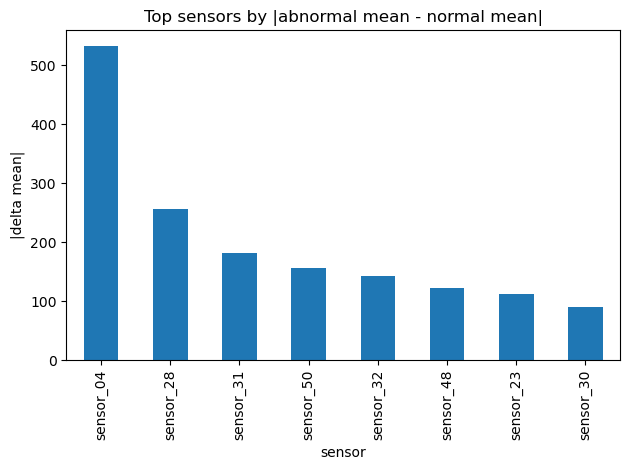

2026-01-04 05:10:44,616 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:44.616044+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'plot_top_shifts', 'message': 'Plotted sensors with largest mean shifts', 'why': None, 'consequence': None, 'data': {'top_sensors': ['sensor_04', 'sensor_28', 'sensor_31', 'sensor_50', 'sensor_32', 'sensor_48', 'sensor_23', 'sensor_30']}}


{'ts_utc': '2026-01-04T05:10:44.616044+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'plot_top_shifts',
 'message': 'Plotted sensors with largest mean shifts',
 'why': None,
 'consequence': None,
 'data': {'top_sensors': ['sensor_04',
   'sensor_28',
   'sensor_31',
   'sensor_50',
   'sensor_32',
   'sensor_48',
   'sensor_23',
   'sensor_30']}}

In [33]:
top = stats["delta__mean"].abs().sort_values(ascending=False).head(TOP_PLOT_COLS)
display(top.to_frame("abs_delta_mean"))

plt.figure()
top.plot(kind="bar")
plt.title("Top sensors by |abnormal mean - normal mean|")
plt.xlabel("sensor")
plt.ylabel("|delta mean|")
plt.tight_layout()
plt.show()

ledger.add(
    kind="step",
    step="plot_top_shifts",
    message="Plotted sensors with largest mean shifts",
    data={"top_sensors": top.index.tolist()},
    logger=logger,
)


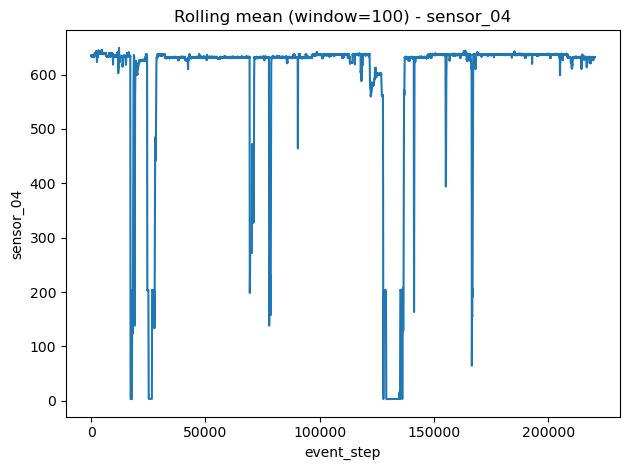

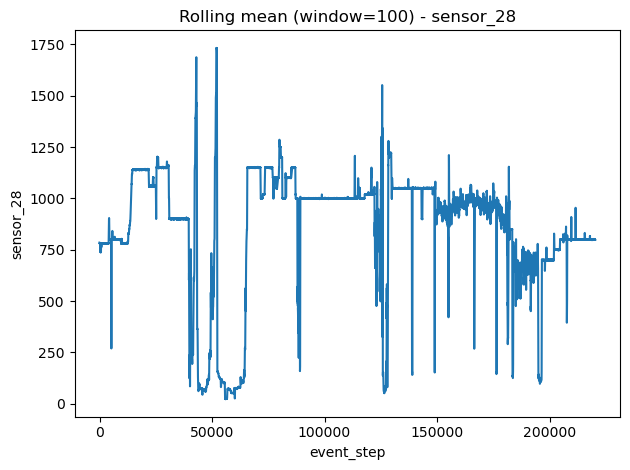

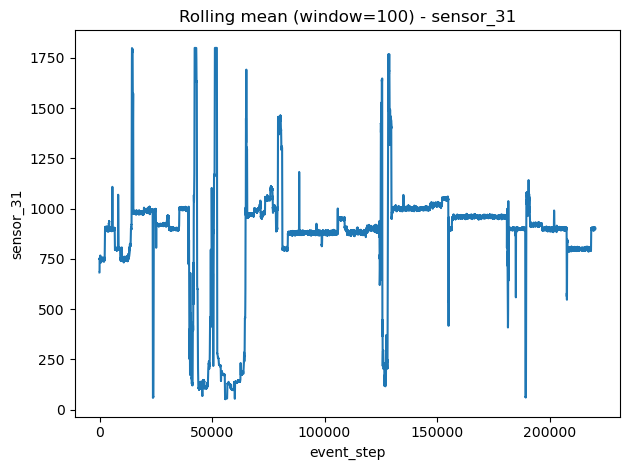

2026-01-04 05:10:45,482 | INFO | capstone.silver | LEDGER | {'ts_utc': '2026-01-04T05:10:45.482440+00:00', 'stage': 'silver', 'recipe': 'silver__clean__dataset__agnostic__v001', 'kind': 'step', 'step': 'rolling_plots', 'message': 'Generated rolling mean plots for representative sensors', 'why': None, 'consequence': None, 'data': {'window': 100, 'sensors': ['sensor_04', 'sensor_28', 'sensor_31']}}


{'ts_utc': '2026-01-04T05:10:45.482440+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'rolling_plots',
 'message': 'Generated rolling mean plots for representative sensors',
 'why': None,
 'consequence': None,
 'data': {'window': 100, 'sensors': ['sensor_04', 'sensor_28', 'sensor_31']}}

In [34]:
window = int(ROLLING_WINDOW)
plot_sensors = top.index.tolist()[:3] if len(top) else numeric_sensors[:3]

for s in plot_sensors:
    plt.figure()
    series = dataframe[s].astype(float)
    plt.plot(series.rolling(window=window, min_periods=1).mean())
    plt.title(f"Rolling mean (window={window}) - {s}")
    plt.xlabel("event_step")
    plt.ylabel(s)
    plt.tight_layout()
    plt.show()

ledger.add(
    kind="step",
    step="rolling_plots",
    message="Generated rolling mean plots for representative sensors",
    data={"window": window, "sensors": plot_sensors},
    logger=logger,
)


In [35]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

In [36]:
# Save Data as Parquet
save_data(dataframe, SILVER_TRAIN_DATA_PATH, SILVER_TRAIN_DATA_FILE_NAME)

ledger.add(
    kind="step",
    step="export_silver",
    message="Saved Silver parquet",
    data={"silver_dir": str(SILVER_TRAIN_DATA_PATH), "file_stem": "pump__silver__train"},
    logger=logger,
)


2026-01-04 05:10:46,045 | INFO | capstone.file_io | Saving DataFrame to Parquet: /workspace/data/silver/train/pump__silver__train.parquet
2026-01-04 05:10:47,837 | INFO | capstone.file_io | Saved: pump__silver__train.parquet | shape=(220320, 72) | columns=['meta__dataset', 'meta__split', 'meta__run_id', 'meta__asset_id', 'meta__label_type', 'meta__label_source', 'meta__ingested_at_utc', 'meta__source_file', 'meta__source_row_id', 'meta__record_id', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', '

{'ts_utc': '2026-01-04T05:10:47.839921+00:00',
 'stage': 'silver',
 'recipe': 'silver__clean__dataset__agnostic__v001',
 'kind': 'step',
 'step': 'export_silver',
 'message': 'Saved Silver parquet',
 'why': None,
 'consequence': None,
 'data': {'silver_dir': '/workspace/data/silver/train',
  'file_stem': 'pump__silver__train'}}

In [38]:
ledger_path = ledger.write_json(SILVER_ARTIFACTS_PATH / "silver_ledger.json")
wandb.save(str(ledger_path))  

metrics, saved = profile_dataframe(dataframe, logger, artifacts_dir=SILVER_ARTIFACTS_PATH, head=15)
if isinstance(metrics, dict):
    wandb_run.log(metrics)

finalize_wandb_stage(
    wandb_run,
    stage="silver",
    dataframe=dataframe,
    project_root=paths.root,
    logs_dir=paths.logs,
    dataset_dirs=[paths.data_silver_train],
    dataset_artifact_name="pump-silver-train-parquet",
    notebook_path=paths.notebooks / "EDA_Notebook_01_Pump.ipynb",
    profile=False,
)

wandb_run.finish()
logger.info("W&B run finished.")


2026-01-04 05:11:06,494 | INFO | capstone.silver | Shape: (220320, 72)
2026-01-04 05:11:06,496 | INFO | capstone.silver | Memory (MB): 267.95
2026-01-04 05:11:06,500 | INFO | capstone.silver | Dtypes:
meta__dataset                       category
meta__split                         category
meta__run_id                          object
meta__asset_id                        object
meta__label_type                      object
meta__label_source                    object
meta__ingested_at_utc    datetime64[us, UTC]
meta__source_file             string[python]
meta__source_row_id                    int64
meta__record_id                       uint64
timestamp                             object
sensor_00                            float64
sensor_01                            float64
sensor_02                            float64
sensor_03                            float64
sensor_04                            float64
sensor_05                            float64
sensor_06                         

anomaly_0,▁
anomaly_1,▁
bronze_cols,▁
bronze_rows,▁
cols,▁▁▁
dropped_sensors_missingness_count,▁
event_time_parse_success_pct,▁
median_sampling_interval_sec,▁
memory_mb,█▁▁▁
numeric_sensor_count,▁
rows,▁▁▁


2026-01-04 05:11:17,886 | INFO | capstone.silver | W&B run finished.


In [ ]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 